<a href="https://colab.research.google.com/github/antoniodragoc/Projeto-de-Graduacao-Antonio-Drago-Caetano/blob/main/2_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Conv2D

In [3]:
# Caminhos de treino e validação

# Obs - no diretório dados os dados estão separados em 75% treino 15% validação e 10% teste

path_train = 'C:/Users/Administrador/Meu Drive/Doutorado/UFES-Elétrica/Implementação Jacques Facon K means/Códigos/Artigo/dados/train/'
path_val = 'C:/Users/Administrador/Meu Drive/Doutorado/UFES-Elétrica/Implementação Jacques Facon K means/Códigos/Artigo/dados/val/'
batch_size = 20


In [5]:
# Gerando os dados a partir das imagens
train_datagen = ImageDataGenerator(    
    rotation_range = 90,
    vertical_flip = True,
    horizontal_flip = True,
    zoom_range=0.05,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode = 'reflect',
    samplewise_center = True,
    samplewise_std_normalization = True
    )

val_datagen = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True
    )


test_datagen = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True
    )


In [6]:
# dados de treino
train_generator = train_datagen.flow_from_directory(
    path_train,
    target_size = (299, 299),
    batch_size= batch_size,
    shuffle=True,
    class_mode='categorical' 
)

#dados de validação
val_generator = val_datagen.flow_from_directory(
    path_val,
    target_size = (299, 299),
    batch_size= batch_size,  
    shuffle=True,
    class_mode='categorical'     
)

Found 518 images belonging to 2 classes.
Found 104 images belonging to 2 classes.


In [7]:
y_true = train_generator.classes

In [9]:
val_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
# Chamando a rede pré-treinada
conv_model = VGG19(
    weights='imagenet', 
    include_top=True, 
    )

conv_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
# Chamando a rede pré-treinada
conv_model = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(299,299,3))

first_freeze_layers = 20 #number of the first layers to freeze
for layer in conv_model.layers[0:first_freeze_layers]:
    layer.trainable = False

teste = keras.layers.Flatten()(conv_model.output)

# three hidden layers
teste = keras.layers.Dropout(0.4)(teste)
teste = keras.layers.Dense(128, activation='relu')(teste)
teste = keras.layers.Dense(64, activation='relu')(teste)

# final softmax layer with two categories
predictions = keras.layers.Dense(2, activation='softmax')(teste)

# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

full_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0     

In [12]:
#EARLY STOPPING ADICIONADO
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=100,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True
)

lr_schedule = keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate = 0.001, 
    first_decay_steps = 500, 
    t_mul=2.4, 
    m_mul=1.3, 
    alpha=0.001, 
    name=None
)

In [13]:
# Compilando o modelo
full_model.compile(loss='categorical_crossentropy',
                  optimizer= keras.optimizers.SGD(learning_rate=lr_schedule),
                  metrics=['accuracy'])

# Treinando o modelo com os dados de treino e teste
history = full_model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 200,
    callbacks=[callback]
)

Epoch 1/200
26/26 [==============================] - 194s 7s/step - loss: 0.7300 - accuracy: 0.5290 - val_loss: 0.6598 - val_accuracy: 0.5481
Epoch 2/200
26/26 [==============================] - 188s 7s/step - loss: 0.6994 - accuracy: 0.5425 - val_loss: 0.6527 - val_accuracy: 0.6923
Epoch 3/200
26/26 [==============================] - 186s 7s/step - loss: 0.6916 - accuracy: 0.5463 - val_loss: 0.6371 - val_accuracy: 0.7115
Epoch 4/200
26/26 [==============================] - 183s 7s/step - loss: 0.6865 - accuracy: 0.5714 - val_loss: 0.6179 - val_accuracy: 0.7885
Epoch 5/200
26/26 [==============================] - 183s 7s/step - loss: 0.6768 - accuracy: 0.5830 - val_loss: 0.6364 - val_accuracy: 0.6635
Epoch 6/200
26/26 [==============================] - 11732s 469s/step - loss: 0.6804 - accuracy: 0.5811 - val_loss: 0.6225 - val_accuracy: 0.7404
Epoch 7/200
26/26 [==============================] - 195s 8s/step - loss: 0.6686 - accuracy: 0.5869 - val_loss: 0.5729 - val_accuracy: 0.7788
Ep

26/26 [==============================] - 181s 7s/step - loss: 0.5362 - accuracy: 0.7452 - val_loss: 0.4698 - val_accuracy: 0.7692
Epoch 59/200
26/26 [==============================] - 181s 7s/step - loss: 0.5445 - accuracy: 0.7066 - val_loss: 0.4699 - val_accuracy: 0.7692
Epoch 60/200
26/26 [==============================] - 182s 7s/step - loss: 0.5423 - accuracy: 0.7355 - val_loss: 0.4710 - val_accuracy: 0.7692
Epoch 61/200
26/26 [==============================] - 181s 7s/step - loss: 0.5261 - accuracy: 0.7413 - val_loss: 0.4727 - val_accuracy: 0.7596
Epoch 62/200
26/26 [==============================] - 181s 7s/step - loss: 0.5320 - accuracy: 0.7375 - val_loss: 0.4715 - val_accuracy: 0.7692
Epoch 63/200
26/26 [==============================] - 181s 7s/step - loss: 0.5415 - accuracy: 0.7143 - val_loss: 0.4711 - val_accuracy: 0.7692
Epoch 64/200
26/26 [==============================] - 180s 7s/step - loss: 0.5414 - accuracy: 0.7181 - val_loss: 0.4712 - val_accuracy: 0.7692
Epoch 65/200

26/26 [==============================] - 180s 7s/step - loss: 0.4768 - accuracy: 0.7683 - val_loss: 0.5098 - val_accuracy: 0.7212
Epoch 116/200
26/26 [==============================] - 178s 7s/step - loss: 0.4989 - accuracy: 0.7683 - val_loss: 0.4810 - val_accuracy: 0.7500
Epoch 117/200
26/26 [==============================] - 178s 7s/step - loss: 0.4869 - accuracy: 0.7722 - val_loss: 0.4713 - val_accuracy: 0.8077
Epoch 118/200
26/26 [==============================] - 178s 7s/step - loss: 0.4794 - accuracy: 0.7683 - val_loss: 0.5279 - val_accuracy: 0.7115
Epoch 119/200
26/26 [==============================] - 178s 7s/step - loss: 0.4890 - accuracy: 0.7645 - val_loss: 0.4800 - val_accuracy: 0.7596
Epoch 120/200
26/26 [==============================] - 178s 7s/step - loss: 0.4805 - accuracy: 0.7606 - val_loss: 0.4779 - val_accuracy: 0.7500
Epoch 121/200
26/26 [==============================] - 183s 7s/step - loss: 0.4775 - accuracy: 0.7490 - val_loss: 0.4707 - val_accuracy: 0.7596
Epoch 

Epoch 172/200
26/26 [==============================] - 177s 7s/step - loss: 0.4330 - accuracy: 0.8050 - val_loss: 0.4817 - val_accuracy: 0.7404
Epoch 173/200
26/26 [==============================] - 181s 7s/step - loss: 0.4357 - accuracy: 0.8031 - val_loss: 0.4813 - val_accuracy: 0.7404
Epoch 174/200
26/26 [==============================] - 181s 7s/step - loss: 0.4422 - accuracy: 0.7954 - val_loss: 0.4813 - val_accuracy: 0.7404
Epoch 175/200
26/26 [==============================] - 181s 7s/step - loss: 0.4557 - accuracy: 0.7876 - val_loss: 0.4815 - val_accuracy: 0.7404
Epoch 176/200
26/26 [==============================] - 181s 7s/step - loss: 0.4594 - accuracy: 0.7780 - val_loss: 0.4814 - val_accuracy: 0.7404
Epoch 177/200
26/26 [==============================] - 181s 7s/step - loss: 0.5026 - accuracy: 0.7548 - val_loss: 0.5092 - val_accuracy: 0.7115
Epoch 178/200
26/26 [==============================] - 181s 7s/step - loss: 0.4706 - accuracy: 0.7741 - val_loss: 0.4828 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


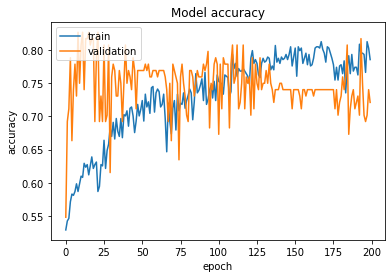

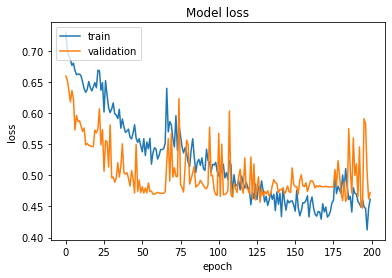

In [14]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
#dados de teste
path_test = 'C:/Users/Administrador/Meu Drive/Doutorado/UFES-Elétrica/Implementação Jacques Facon K means/Códigos/Artigo/dados/test/'
test_generator =  test_datagen.flow_from_directory(
    path_test,
    target_size = (299, 299),
    shuffle = False,
    batch_size= batch_size,
    class_mode='categorical'     
    )

Found 70 images belonging to 2 classes.


In [16]:
#Confution Matrix and Classification Report

from sklearn.metrics import confusion_matrix, classification_report
Y_pred = full_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

cmvgg = confusion_matrix(test_generator.classes, y_pred )

4/4 [==============================] - 18s 4s/step


In [18]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

confusion_matrix(test_generator.classes, y_pred )


array([[17, 18],
       [ 3, 32]], dtype=int64)

In [20]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.49      0.62        35
           1       0.64      0.91      0.75        35

    accuracy                           0.70        70
   macro avg       0.74      0.70      0.69        70
weighted avg       0.75      0.70      0.69        70



Text(0.5, 12.5, 'Predicted label')

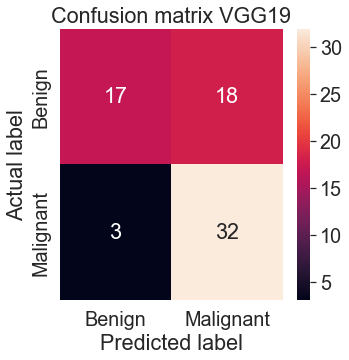

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(5,5))
x_axis_labels = ['Benign','Malignant'] # labels for x-axis
y_axis_labels = ['Benign','Malignant'] # labels for y-axis
ax = sns.heatmap(cm, annot=True, fmt="d",xticklabels=x_axis_labels, yticklabels=y_axis_labels)
sns.set(font_scale=1.8)
plt.title('Confusion matrix VGG19')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')